In [16]:
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Get data
df_2101 = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet')
df_2102 = pd.read_parquet('https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet')



In [5]:
# Q1. Records in January 2021
df_2101.shape

(1154112, 7)

In [39]:
# Q2. What's the average trip duration in January?
df_2101['duration'] = df_2101['dropOff_datetime'] - df_2101['pickup_datetime'] 
df_2101['duration'] = df_2101['duration'].dt.total_seconds() / 60
df_2101['duration'].mean()

19.1672240937939

In [15]:
# Data Prep.keep only the records where the duration was between 1 and 60 minutes (inclusive). How many records did you drop?
df_2101['duration'].describe()

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

<AxesSubplot:ylabel='Density'>

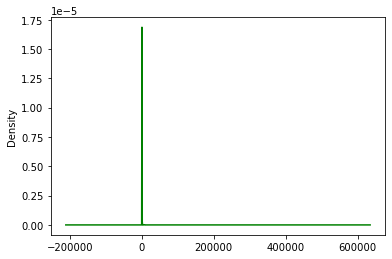

In [17]:
df_2101['duration'].plot.density(color='green')

/home/ubuntu/yes/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

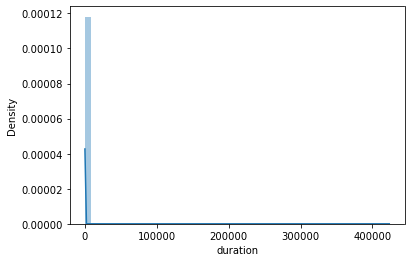

In [40]:
sns.distplot(df_2101['duration'])

In [20]:
df = df_2101[(df_2101['duration']>=1) & (df_2101['duration']<=60)]
df_2101.shape[0] - df.shape[0]

44286

In [24]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,NaN,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000


In [25]:
# Q3. Fractions of missing values for the pickup location ID?
df['PUlocationID'].fillna(-1, inplace=True)
df['DOlocationID'].fillna(-1, inplace=True)

/tmp/ipykernel_2833/2498020867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUlocationID'].fillna(-1, inplace=True)
/tmp/ipykernel_2833/2498020867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOlocationID'].fillna(-1, inplace=True)


In [28]:
sum(df['PUlocationID'] == -1) / df.shape[0]

0.8352732770722617

In [35]:
# Q4. apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

# * Turn the dataframe into a list of dictionaries
# * Fit a dictionary vectorizer 
# * Get a feature matrix from it

categorical = ['PUlocationID', 'DOlocationID']

df[categorical] = df[categorical].astype(str)

train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# What's the dimensionality of this matrix? 
X_train.shape[1]


/tmp/ipykernel_2833/63162068.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


525

In [36]:
# Q5. Train a plain linear regression model with default parameters. Calculate the RMSE of the model on the training data

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107206316

In [37]:
# Q6. RMSE on validation set (Feb 2022)
df_2102['duration'] = df_2102['dropOff_datetime'] - df_2102['pickup_datetime'] 
df_2102['duration'] = df_2102['duration'].apply(lambda x: x.total_seconds() / 60)
df = df_2102[(df_2102['duration']>=1) & (df_2102['duration']<=60)]

df['PUlocationID'].fillna(-1, inplace=True)
df['DOlocationID'].fillna(-1, inplace=True)

categorical = ['PUlocationID', 'DOlocationID']

df[categorical] = df[categorical].astype(str)

validation_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_validation = dv.fit_transform(validation_dicts)

target = 'duration'
y_validation = df[target].values

y_pred = lr.predict(X_validation)

mean_squared_error(y_validation, y_pred, squared=False)

/tmp/ipykernel_2833/3781829066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUlocationID'].fillna(-1, inplace=True)
/tmp/ipykernel_2833/3781829066.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOlocationID'].fillna(-1, inplace=True)
/tmp/ipykernel_2833/3781829066.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str

ValueError: X has 526 features, but LinearRegression is expecting 525 features as input.